In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs/src/master/

Cloning into 'master'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [0]:
!ls master

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

from keras.callbacks import LearningRateScheduler, ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


In [0]:
np.random.seed(0)

#### Preprocessing of the data




In [0]:
# Unpickling the data (.p is a special format for pickles)
with open('master/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('master/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('master/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))

#Extracting the data from unpickled dictionaries:
X_train, y_train = train_data['features'], train_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
X_val, y_val = val_data['features'], val_data['labels']


<class 'dict'>


In [0]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not as should be (32x32x3)"

assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not as should be (32x32x3)"

assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not as should be (32x32x3)"


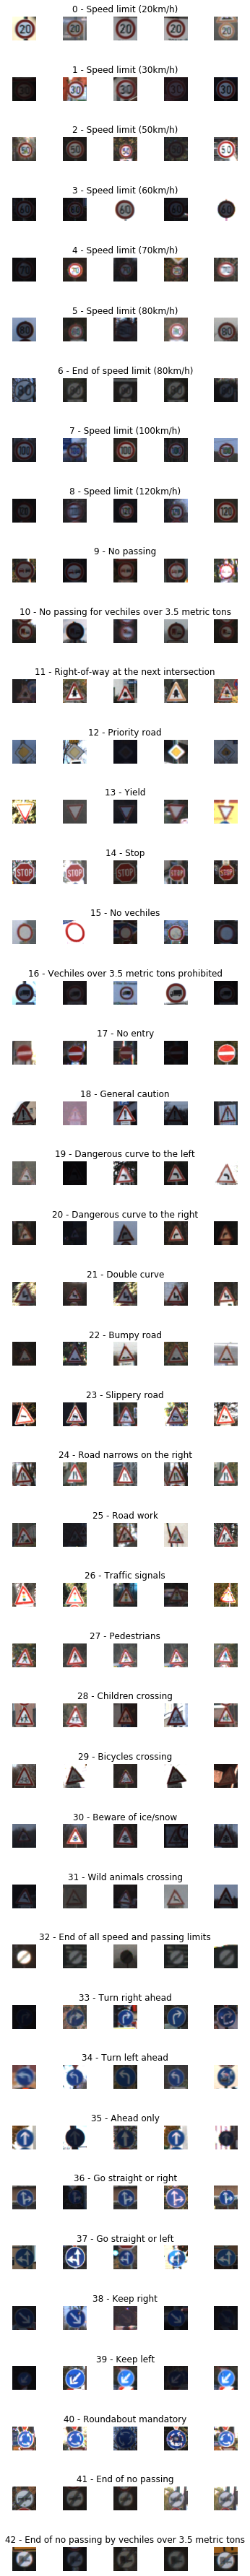

In [0]:
#Printing all possible classes in our dataset
data = pd.read_csv('master/signnames.csv')
num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


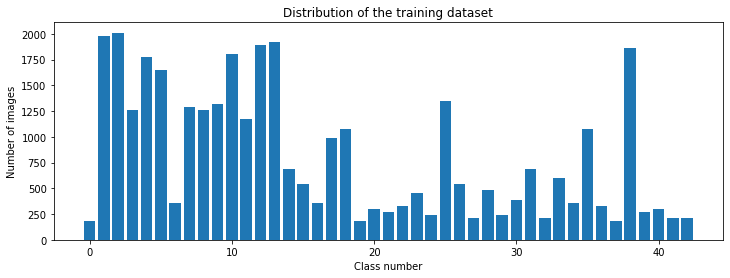

In [0]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


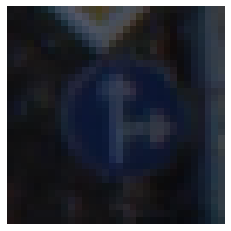

In [0]:
import cv2
plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


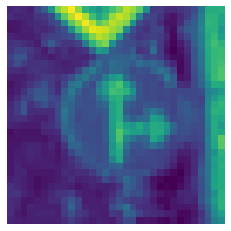

In [0]:
#Simply converting from RGB to GrayScale
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis('off')
print(img.shape)

(32, 32)


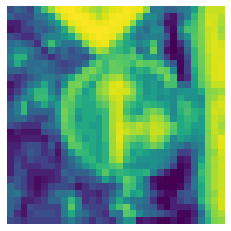

In [0]:
#Histogram equalizer --> the algorithm is to spread the high intensity value across the image matrix
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  #Normalization technique for efficiency goals
  img = img / 255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


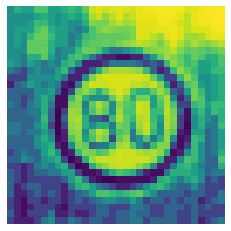

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

(15, 32, 32, 1)


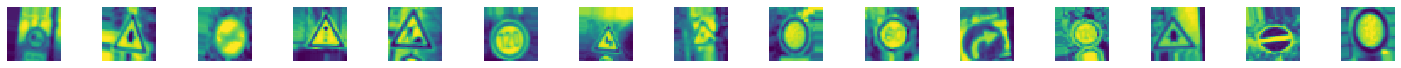

In [0]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)

batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [0]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [0]:
#previous standard lenet
'''def leNet_model():
  model = Sequential()
  model.add(Conv2D(30, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Conv2D(15, (3, 3), activation = 'relu'))                            
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))

  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model'''

"def leNet_model():\n  model = Sequential()\n  model.add(Conv2D(30, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))\n  model.add(MaxPooling2D(pool_size = (2, 2)))\n  model.add(Conv2D(15, (3, 3), activation = 'relu'))                            \n  model.add(MaxPooling2D(pool_size=(2, 2)))\n\n  model.add(Flatten())\n  model.add(Dense(500, activation = 'relu'))\n  model.add(Dropout(0.5))\n  model.add(Dense(num_classes, activation = 'softmax'))\n\n  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])\n  return model"

In [0]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu')) #30 --> 60
  model.add(Conv2D(60, (5, 5), activation = 'relu'))                            #added convlayer
  model.add(MaxPooling2D(pool_size = (2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation = 'relu'))                            #15 --> 30
  model.add(Conv2D(30, (3, 3), activation = 'relu'))                            #added convlayer
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))

  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy']) # 0.01 --> 0.001
  return model

In [0]:
model = modified_model()
print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0        

In [0]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=2000,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





2000/2000 [==============================] - 70s 35ms/step - loss: 0.9123 - acc: 0.7326 - val_loss: 0.0925 - val_acc: 0.9671
Epoch 2/10
2000/2000 [==============================] - 56s 28ms/step - loss: 0.2138 - acc: 0.9335 - val_loss: 0.0649 - val_acc: 0.9803
Epoch 3/10
2000/2000 [==============================] - 57s 29ms/step - loss: 0.1499 - acc: 0.9536 - val_loss: 0.0458 - val_acc: 0.9857
Epoch 4/10
2000/2000 [==============================] - 57s 29ms/step - loss: 0.1168 - acc: 0.9640 - val_loss: 0.0662 - val_acc: 0.9794
Epoch 5/10
2000/2000 [==============================] - 57s 29ms/step - loss: 0.0979 - acc: 0.9702 - val_loss: 0.0423 - val_acc: 0.9884
Epoch 6/10
2000/2000 [==============================] - 57s 29ms/step - loss: 0.0853 - acc: 0.9737 - val_loss: 0.0336 - val_acc: 0.9905
Epoch 7/10
2000/2000 [==============================] - 56s 28ms/step - loss: 0.07

Text(0.5, 0, 'epoch')

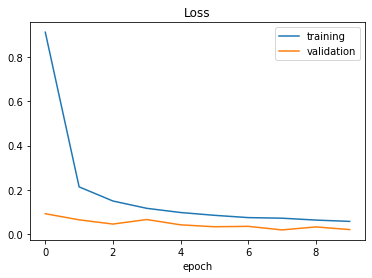

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

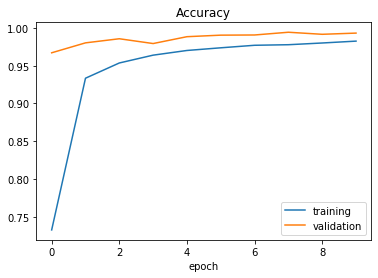

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
 
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.09834230618692354
Test accuracy: 0.9768804434359498


## Testing part of the model

(-0.5, 1299.5, 955.5, -0.5)

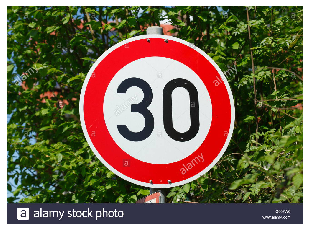

In [0]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream = True)
img = Image.open(r.raw)
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.axis('off')

(32, 32)


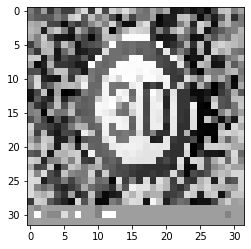

In [0]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [0]:
img = img.reshape(1, 32, 32, 1)

In [0]:
print('predicted sign: ' + str(model.predict_classes(img)))

predicted sign: [1]
